In [1]:
import sys
import torch
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np

from scripts.RNTN_v2 import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Working on {}'.format(device))

Working on cpu


## Accuracy with d=30

In [3]:
net = RNTN(device, len(word2idx), d=30)
net.to(device)

RNTN(
  (L): Embedding(22349, 30)
  (W): Linear(in_features=60, out_features=30, bias=True)
  (Ws): Linear(in_features=30, out_features=5, bias=True)
  (lSoftmax): LogSoftmax()
)

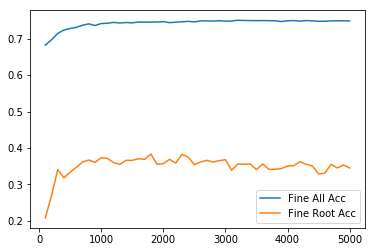

In [4]:
d30DevAcc = np.genfromtxt('../data/trainingD30DevAcc.csv', delimiter=',')
plt.figure()
plt.plot(d30DevAcc[0], d30DevAcc[1], label='Fine All Acc')
plt.plot(d30DevAcc[0], d30DevAcc[2], label='Fine Root Acc')
plt.legend()
plt.show()

In [5]:
testAllAcc, testRootAcc = getAccuracyScores(net, bank['test'], device, '../savedModels/d30/net_5000.pth')
print('TEST: Fine ALL: {}'.format(testAllAcc))
print('TEST: Fine Root: {}'.format(testRootAcc))

TEST: Fine ALL: 0.7458232445520581
TEST: Fine Root: 0.3552036199095023


# Compare embedding size

In [6]:
d30DevAcc = np.genfromtxt('../data/trainingD30DevAcc.csv', delimiter=',')
d50DevAcc = np.genfromtxt('../data/trainingD50DevAcc.csv', delimiter=',')
d52DevAcc = np.genfromtxt('../data/trainingD52DevAcc.csv', delimiter=',')
d75DevAcc = np.genfromtxt('../data/trainingD75DevAcc.csv', delimiter=',')
d100DevAcc = np.genfromtxt('../data/trainingD100DevAcc.csv', delimiter=',')

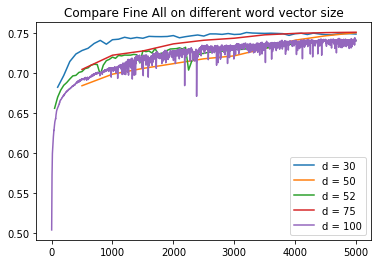

In [7]:
plt.figure()
plt.plot(d30DevAcc[0], d30DevAcc[1], label='d = 30')
plt.plot(d50DevAcc[0], d50DevAcc[1], label='d = 50')
plt.plot(d52DevAcc[0], d52DevAcc[1], label='d = 52')
plt.plot(d75DevAcc[0], d75DevAcc[1], label='d = 75')
plt.plot(d100DevAcc[0], d100DevAcc[1], label='d = 100')
plt.legend()
plt.title('Compare Fine All on different word vector size')
plt.show()

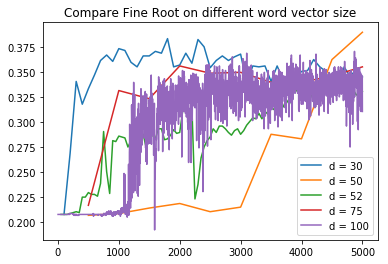

In [8]:
plt.figure()
plt.plot(d30DevAcc[0], d30DevAcc[2], label='d = 30')
plt.plot(d50DevAcc[0], d50DevAcc[2], label='d = 50')
plt.plot(d52DevAcc[0], d52DevAcc[2], label='d = 52')
plt.plot(d75DevAcc[0], d75DevAcc[2], label='d = 75')
plt.plot(d100DevAcc[0], d100DevAcc[2], label='d = 100')
plt.legend()
plt.title('Compare Fine Root on different word vector size')
plt.show()

## Compare fineAll and fineRootTarget

In [9]:
d30OptimComp = np.genfromtxt('../data/d30OptimComp.csv', delimiter=',')
d50OptimComp = np.genfromtxt('../data/d50OptimComp.csv', delimiter=',')
d75OptimComp = np.genfromtxt('../data/d75OptimComp.csv', delimiter=',')

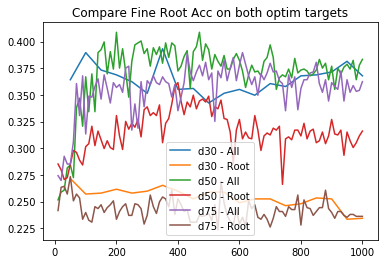

In [12]:
plt.figure()
plt.plot(d30OptimComp[0], d30OptimComp[2], label='d30 - All')
plt.plot(d30OptimComp[0], d30OptimComp[4], label='d30 - Root')
plt.plot(d50OptimComp[0], d50OptimComp[1], label='d50 - All')
plt.plot(d50OptimComp[0], d50OptimComp[2], label='d50 - Root')
plt.plot(d75OptimComp[0], d75OptimComp[1], label='d75 - All')
plt.plot(d75OptimComp[0], d75OptimComp[2], label='d75 - Root')
plt.legend()
plt.title('Compare Fine Root Acc on both optim targets')
plt.show()

In [ ]:
testAllAcc, testRootAcc = getAccuracyScores(net, bank['test'], device, '../savedModels/d30/fineAll/net_1000.pth')
print('TEST: All: Fine ALL: {}'.format(testAllAcc))
print('TEST: All: Fine Root: {}'.format(testRootAcc))
print('------------------------------------------')

testAllAcc, testRootAcc = getAccuracyScores(net, bank['test'], device, '../savedModels/d30/fineRoot/net_1000.pth')
print('TEST: Root: Fine ALL: {}'.format(testAllAcc))
print('TEST: Root: Fine Root: {}'.format(testRootAcc))